In [140]:
#LOG_PATH   = "/Volumes/aine_store/SLE+MPOX+September+2025Sept11/CLADE+Artic/Districts+EXP339/COMBINED+District+DTA.log"
#LOG_PATH2  = "/Volumes/aine_store/SLE+MPOX+September+2025Sept11/Mask+SLE+Artic+25sept17/ALL+SLE+Cladeiib+25sept17.log"
#TREE_PATH  = "/Volumes/aine_store/SLE+MPOX+September+2025Sept11/CLADE+Artic/Districts+EXP339/Combined+dta+district.mcc.tree"
#MJHIST_CSV = "/Volumes/aine_store/SLE+MPOX+September+2025Sept11/CLADE+Artic/Districts+EXP339/Combined+DTA+SLE+District.history.MJ.csv"


In [141]:
# =======================
# 4-PANEL FIGURE (A–D)
# =======================
import baltic as bt
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import datetime as dt
from scipy.stats import gaussian_kde
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
import matplotlib.dates as mdates
import re
from PyAstronomy import pyasl
from collections import defaultdict
import csv
import geopandas as gpd
from matplotlib import cm
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from calendar import isleap

mpl.rcParams.update({'xtick.labelsize': 25, 'ytick.labelsize': 25})


In [142]:
mpl.rcParams['font.family'] = 'sans-serif'



# ─────────────────────────────────────────
# Paths
# ─────────────────────────────────────────
LOG_PATH   = "/Volumes/aine_store/SLE+MPOX+September+2025Sept11/CLADE+Artic/Districts+EXP339/COMBINED+District+DTA.log"
LOG_PATH2  = "/Volumes/aine_store/SLE+MPOX+September+2025Sept11/Mask+SLE+Artic+25sept17/ALL+SLE+Cladeiib+25sept17.log"
TREE_PATH  = "/Volumes/aine_store/SLE+MPOX+September+2025Sept11/CLADE+Artic/Districts+EXP339/Combined+dta+district.mcc.tree"
MJHIST_CSV = "/Volumes/aine_store/SLE+MPOX+September+2025Sept11/CLADE+Artic/Districts+EXP339/Combined+DTA+SLE+District.history.MJ.csv"

# Panel D sources
GADM_JSON  = "/Volumes/aine_store/gadm41_SLE_2.json"
EDGES_CSV  = "/Volumes/aine_store/SLE+MPOX+September+2025Sept11/CONT+phy300M/SLE+CONT_mcc_data.csv"
#EDGES_CSV  = "/Volumes/aine_store/CONT_phylo_2025-08-16/CONT+PHYLO+2025-08-16/SLE+CONT_mcc_data.csv"

# ─────────────────────────────────────────
# Load MCC tree once
# ─────────────────────────────────────────
ll = bt.loadNexus(TREE_PATH)
ll.traverse_tree(); ll.treeStats(); ll.sortBranches()

# ─────────────────────────────────────────
# Shared palettes / helpers
# ─────────────────────────────────────────
def canon(x: str) -> str:
    return re.sub(r"[^a-z0-9]+", "", str(x).lower())

PRETTY = {
    "bo":"Bo","bonthe":"Bonthe","bombali":"Bombali","falaba":"Falaba",
    "kambia":"Kambia","koinadugu":"Koinadugu","kailahun":"Kailahun",
    "kenema":"Kenema","kono":"Kono","portloko":"Port Loko",
    "pujehun":"Pujehun","tonkolili":"Tonkolili", "Falaba":"Falaba",
    "westernurban":"Western Urban","westernrural":"Western Rural"
}
COLOR = {
    "bo": "#A0CBE8", "bonthe": "#F1CE63", "bombali": "#4E79A7", "falaba": "#79706E",
    "kambia": "#499894", "koinadugu": "#79706E", "kailahun": "#8CD17D", "kenema": "#B6992D",
    "kono": "#F28E2B", "portloko": "#86BCB6", "pujehun": "#FFBE7D","Falaba":"#eeeeee",
    "tonkolili": "#59A14F", "westernrural": "#BAB0AC", "westernurban": "#E15759",
    # Extras sometimes present in GADM v4.1:
    "moyamba": "#B07AA1", "karene": "#9C755F"
}
def col_for(name, default="#888888"):
    return COLOR.get(canon(name), default)
def pretty(name):
    return PRETTY.get(canon(name), str(name).title())


Tree height: 0.779244
Tree length: 46.818514
strictly bifurcating tree
annotations present

Numbers of objects in tree: 677 (338 nodes and 339 leaves)



In [143]:

# ─────────────────────────────────────────
# PANEL A: Tree + KDE ribbons
# ─────────────────────────────────────────
def panel_A_tree(ax):
    DISPLAY_FIX = {
        "port-loko":"portloko","portloko":"portloko",
        "western urban":"westernurban","western-urban":"westernurban",
        "western rural":"westernrural","western-rural":"westernrural",
        "tongo":"kenema","falaba":"koinadugu","nan":"westernurban",
    }
    def canonicalize_raw(loc_raw):
        if loc_raw is None: return "westernurban"
        loc = str(loc_raw).strip()
        key = DISPLAY_FIX.get(loc.lower(), canon(loc))
        for k,v in PRETTY.items():
            if key == k: return v
        return loc.title()
    def node_color(node):
        return col_for(canonicalize_raw(node.traits.get("location")))

    ll.plotTree(ax, x_attr=lambda k: k.absoluteTime, colour=node_color)
    ll.plotPoints(ax, x_attr=lambda k: k.absoluteTime, size=200,
                  colour=node_color, zorder=100)

    times = [n.absoluteTime for n in ll.Objects]
    xmin, xmax = min(times), max(times)
    # 2-month bands
    start = dt.datetime(int(np.floor(xmin)), 1, 1)
    end   = dt.datetime(int(np.ceil(xmax)),  1, 1)
    dates = []
    yr, mo = start.year, start.month
    while True:
        dates.append(dt.datetime(yr, mo, 1))
        mo += 2
        if mo > 12:
            yr += mo // 12; mo = mo % 12
        if dt.datetime(yr, mo, 1) > end: break
    for i in range(len(dates)-1):
        if i % 2 == 0:
            d0, d1 = dates[i], dates[i+1]
            x0 = d0.year + (d0.month-1)/12.0
            x1 = d1.year + (d1.month-1)/12.0
            ax.axvspan(x0, x1, facecolor="#F5F5F5", alpha=0.6, zorder=0)

    tick_pos   = [d.year + (d.month-1)/12.0 for d in dates]
    tick_label = [d.strftime('%Y-%m') for d in dates]
    ax.set_xticks(tick_pos); ax.set_xticklabels(tick_label, rotation=0, ha='right', size=25)
    ax.set_xlim(2024.5, 2025.6); ax.set_yticks([])
    for side in ('top','right','left'): ax.spines[side].set_visible(False)
    ax.tick_params(axis='x', length=0)

    # legend (districts present on tips)
    present, seen = [], set()
    for n in ll.Objects:
        loc = canonicalize_raw(n.traits.get("location"))
        key = canon(loc)
        if key not in seen and key in COLOR:
            seen.add(key); present.append(pretty(loc))
    handles = [Patch(facecolor=COLOR[canon(loc)], edgecolor='black', label=pretty(loc))
               for loc in present]
    ax.legend(handles=handles, title="District", loc="center left",
              frameon=False, fontsize=25, title_fontsize=25)

    # KDEs (root/SLE/stem) on baseline
    def read_beast_log(path):
        return pd.read_csv(path, sep=r"\s+", engine="python", comment="#")
    def drop_burnin(df, frac=0.1):
        if len(df) < 20: return df
        i0 = int(len(df) * frac); return df.iloc[i0:].reset_index(drop=True)
    def find_col(df, candidates):
        cols_lower = {c.lower(): c for c in df.columns}
        for cand in candidates:
            if cand.lower() in cols_lower: return cols_lower[cand.lower()]
        for cand in candidates:
            lc = cand.lower()
            for k, orig in cols_lower.items():
                if lc in k: return orig
        return None
    def extract_series(logs, candidates):
        for df in logs:
            col = find_col(df, candidates)
            if col is not None:
                arr = pd.to_numeric(df[col], errors="coerce").dropna().values
                if arr.size: return arr
        return np.array([])
    def to_absolute_if_age(arr, present_decimal_year):
        if arr.size == 0: return arr
        return present_decimal_year - arr if np.nanmedian(arr) < 300 else arr

    logA = drop_burnin(read_beast_log(LOG_PATH),  0.1)
    logB = drop_burnin(read_beast_log(LOG_PATH2), 0.1)
    logs = [logA, logB]
    x_root = extract_series(logs, ["age(root)","tmrca(root)","rootage","treemodel.rootage"])
    x_sle  = extract_series(logs, ["age(sle)","tmrca(sle)","age(SLE)"])
    x_stem = extract_series(logs, ["age(stemsle)","tmrca(stemsle)","age(stemSLE)","age(stem)"])
    present_dec = max(n.absoluteTime for n in ll.Objects)
    x_root = to_absolute_if_age(x_root, present_dec)
    x_sle  = to_absolute_if_age(x_sle,  present_dec)
    x_stem = to_absolute_if_age(x_stem, present_dec)

    xmin, xmax = ax.get_xlim()
    clip = lambda a: a[(a >= xmin) & (a <= xmax)]
    x_root, x_sle, x_stem = clip(x_root), clip(x_sle), clip(x_stem)

    xs = np.linspace(xmin, xmax, 600)
    def kde_on(xs, arr):
        if arr.size >= 5:
            kde = gaussian_kde(arr); ys = kde(xs)
            return ys, float(ys.max())
        return np.zeros_like(xs), 0.0
    ys_root, pk_root = kde_on(xs, x_root)
    ys_sle,  pk_sle  = kde_on(xs, x_sle)
    ys_stem, pk_stem = kde_on(xs, x_stem)

    ymin, ymax = ax.get_ylim()
    baseline  = ymin; band_h = 0.09 * (ymax - ymin)
    def scale_to_band(y, peak):
        if peak <= 0: return np.full_like(y, baseline)
        return baseline + (y/peak) * band_h

    def plot_kde(xs, yplot, ls="-", z=0.5, alpha=0.22):
        ax.fill_between(xs, baseline, yplot, alpha=alpha, linewidth=0, zorder=z)
        ax.plot(xs, yplot, linewidth=2.5, linestyle=ls, zorder=z+0.1)

    yplot_root = scale_to_band(ys_root, pk_root)
    yplot_sle  = scale_to_band(ys_sle,  pk_sle)
    yplot_stem = scale_to_band(ys_stem, pk_stem)
    if pk_root > 0: plot_kde(xs, yplot_root, "-")
    if pk_sle  > 0: plot_kde(xs, yplot_sle,  "--")
    if pk_stem > 0: plot_kde(xs, yplot_stem, ":")

In [144]:
def panel_B_stacked(ax, MJHIST_CSV=None, ALIASES=None, PRETTY=None, COLOR=None, col_for=None):
    import pandas as pd, numpy as np
    import matplotlib.dates as mdates
    from matplotlib.patches import Patch
    from datetime import datetime as dt
    from PyAstronomy import pyasl

    # ── Defaults if not provided/globals missing ─────────────────────────────
    if MJHIST_CSV is None:
        MJHIST_CSV = globals().get("MJHIST_CSV", None)
    if MJHIST_CSV is None:
        ax.text(0.5, 0.5, "MJHIST_CSV not set", ha="center", va="center", transform=ax.transAxes)
        return

    if ALIASES is None:
        ALIASES = globals().get("ALIASES", {
            "western urban": "westernurban","western-urban":"westernurban",
            "western_urban":"westernurban","westernareaurban":"westernurban",
            "western rural":"westernrural","western-rural":"westernrural",
            "western_rural":"westernrural","westernarearural":"westernrural",
            "port loko":"portloko","port-loko":"portloko","port_loko":"portloko",
        })
    if PRETTY is None:
        PRETTY = globals().get("PRETTY", {
            "bo":"Bo","bonthe":"Bonthe","bombali":"Bombali","falaba":"Falaba",
            "kambia":"Kambia","koinadugu":"Koinadugu","kailahun":"Kailahun",
            "kenema":"Kenema","kono":"Kono","portloko":"Port Loko","pujehun":"Pujehun",
            "tonkolili":"Tonkolili","westernurban":"Western Urban","westernrural":"Western Rural"
        })
    if COLOR is None:
        COLOR = globals().get("COLOR", {
            "bo":"#A0CBE8","bonthe":"#F1CE63","bombali":"#4E79A7","falaba":"#79706E",
            "kambia":"#499894","koinadugu":"#79706E","kailahun":"#8CD17D","kenema":"#B6992D",
            "kono":"#F28E2B","portloko":"#86BCB6","pujehun":"#FFBE7D","tonkolili":"#59A14F",
            "westernrural":"#BAB0AC","westernurban":"#E15759",
        })
    if col_for is None:
        def col_for(name, default="#999999"):
            return COLOR.get(name, default)

    # ── Load & prep ─────────────────────────────────────────────────────────
    MT = pd.read_csv(MJHIST_CSV)
    MT["DD"]    = [pyasl.decimalYearGregorianDate(float(x), "yyyy-mm-dd") for x in MT["time"]]
    MT["year"]  = MT["DD"].str.split("-").str[0].astype(int)
    MT["month"] = MT["DD"].str.split("-").str[1].astype(int)
    MT["cd"]    = pd.to_datetime(MT["year"].astype(str) + "-" + MT["month"].astype(str) + "-01")

    # window
    MT = MT[(MT["year"] > 2024) | ((MT["year"] == 2024) & (MT["month"] >= 8))]
    if MT.empty:
        ax.text(0.5, 0.5, "No data after filter", ha="center", va="center", transform=ax.transAxes)
        return

    # canonicalization
    def canon_series(s):
        return (s.astype(str).str.lower()
                .replace(ALIASES)
                .str.replace(r"[^a-z0-9]+", "", regex=True)
                .replace(ALIASES))
    MT["start_c"] = canon_series(MT["startLocation"])
    MT["end_c"]   = canon_series(MT["endLocation"])

    # monthly mean across trees
    total_trees = MT["treeId"].nunique()
    g = (MT.groupby(["start_c","end_c","cd"])["treeId"]
           .nunique().rename("trees_with_event").reset_index())
    g["mean"] = g["trees_with_event"] / float(total_trees)

    # matrices per pair
    all_months = pd.date_range(g["cd"].min(), g["cd"].max(), freq="MS")
    g["key"] = g["start_c"] + "_" + g["end_c"]
    mats = {key: sub.set_index("cd")["mean"].reindex(all_months, fill_value=0.0)
            for key, sub in g[["key","cd","mean"]].groupby("key")}
    if not mats:
        ax.text(0.5, 0.5, "No migration keys", ha="center", va="center", transform=ax.transAxes)
        return

    # order keys by total mass
    totals = {k: v.sum() for k, v in mats.items()}
    keys_sorted = [k for k,_ in sorted(totals.items(), key=lambda kv: kv[1], reverse=True)]

    # top-4 origins
    start_totals = {}
    for k, series in mats.items():
        s, _ = k.split("_", 1)
        start_totals[s] = start_totals.get(s, 0.0) + series.sum()
    top4_starts = sorted(start_totals, key=start_totals.get, reverse=True)[:4]

    # keep only flows from top-4 origins
    keys_filtered = [k for k in keys_sorted if k.split("_", 1)[0] in top4_starts]
    if not keys_filtered:
        ax.text(0.5, 0.5, "No flows from top-4 origins", ha="center", va="center", transform=ax.transAxes)
        return

    # ── Plot (destination fill, origin outline) ─────────────────────────────
    datetime_x = all_months.to_pydatetime()
    cumulative = np.zeros_like(mats[keys_filtered[0]].to_numpy())
    for k in keys_filtered:
        start_canon, end_canon = k.split("_", 1)
        y = mats[k].to_numpy()
        lower, upper = cumulative, cumulative + y

        ax.fill_between(
            datetime_x, lower, upper,
            facecolor=col_for(end_canon),
            edgecolor=col_for(start_canon, "#000000"),
            linewidth=2.0,
            alpha=0.9,
            zorder=2,
            joinstyle='miter'
        )
        cumulative = upper

    # axes
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.set_ylabel('Mean introductions / month', fontsize=20)
    ax.set_ylim(0, max(0.01, cumulative.max()) * 1.10)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', labelrotation=0, labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_xlim(datetime_x[0], datetime_x[-1])

    # legends from filtered keys
    ends_present, seen = [], set()
    for k in keys_filtered:
        e = k.split("_", 1)[1]
        if e not in seen:
            seen.add(e); ends_present.append(e)
    dest_handles = [Patch(facecolor=col_for(e), edgecolor='none',
                          label=PRETTY.get(e, e.title())) for e in ends_present]
    leg_dest = ax.legend(handles=dest_handles, title="Destination (fill)",
                         loc='upper left', frameon=False, fontsize=20, title_fontsize=12)

    origin_handles = [Patch(facecolor='none', edgecolor=col_for(s, "#000000"),
                            linewidth=2.2, label=PRETTY.get(s, s.title()))
                      for s in top4_starts]
    leg_orig = ax.legend(handles=origin_handles, title="Origin (outline)",
                         loc='upper right', frameon=False, fontsize=20, title_fontsize=20)
    ax.add_artist(leg_dest)

    # vertical marker
    event_date = dt(2025, 1, 10)
    ax.axvline(event_date, color="black", linestyle="--", linewidth=1.5, alpha=0.9, zorder=10)
    y_top = ax.get_ylim()[1]
    ax.annotate("First case report", xy=(event_date, y_top), xytext=(5, 5),
                textcoords="offset points", va="bottom", ha="left", fontsize=20)


In [145]:
# ─────────────────────────────────────────
# PANEL C: Per-migration distributions
# ─────────────────────────────────────────
def panel_C_distributions(ax):
    ldf = pd.read_csv(MJHIST_CSV)
    pdf = (ldf.groupby(["startLocation","endLocation"])["treeId"]
              .apply(list).reset_index())
    pdf["count"] = pdf["treeId"].apply(len)
    pdf["mean"]  = pdf["count"] / ldf["treeId"].nunique()
    pdf = pdf.sort_values("mean", ascending=False)
    pdf = pdf[pdf["mean"] >= 1]

    pdf["startLocation"] = pdf["startLocation"].astype(str).str.title()
    pdf["endLocation"]   = pdf["endLocation"].astype(str).str.title()
    ndf = pdf[["startLocation","endLocation","treeId"]].copy()
    ndf["migration"] = ndf["startLocation"] + "_" + ndf["endLocation"]

    DL = {}
    for mig, xs in zip(ndf["migration"], ndf["treeId"]):
        counts = list(pd.Series(xs).value_counts().values)
        DL[mig] = counts
    if not DL:
        ax.text(0.5, 0.5, "No frequent migrations (mean < 1)",
                ha="center", va="center", transform=ax.transAxes); return

    mx = max(len(v) for v in DL.values())
    for k,v in list(DL.items()):
        arr = list(v)
        if len(arr) < mx: arr += [0]*(mx - len(arr))
        DL[k] = [x if x >= 0 else 0 for x in arr]

    data = pd.DataFrame(DL)
    categories = list(data.columns)
    sorted_categories = sorted(categories, key=lambda c: np.nanmedian(data[c].values))
    start_labels = [c.split("_", 1)[0] for c in sorted_categories]
    end_labels   = [c.split("_", 1)[1] for c in sorted_categories]
    row_labels   = [f"{pretty(e)}" for e in end_labels]
    data_list    = [np.asarray(data[c].values, dtype=float) for c in sorted_categories]
    positions    = np.arange(1, len(sorted_categories)+1)

    xmax = 1
    for i, (vals, pos) in enumerate(zip(data_list, positions)):
        vals = vals[~np.isnan(vals)]
        if len(vals) == 0: continue
        col = col_for(start_labels[i])
        ax.plot(vals, np.full_like(vals, pos), '|', markersize=10,
                markeredgewidth=2, color=col, alpha=0.9, zorder=2)
        med = np.median(vals)
        lo, hi = np.percentile(vals, [2.5, 97.5])
        ax.plot([lo, hi], [pos, pos], '-', color='black', lw=2, zorder=3)
        ax.scatter([med], [pos], s=50, marker='D', facecolor='white',
                   edgecolor='black', linewidths=1, zorder=4)
        xmax = max(xmax, np.max(vals), hi)

    ax.set_yticks(positions); ax.set_yticklabels(row_labels, fontsize=20)
    ax.set_xlabel('Number of introductions', fontsize=20)
    ax.set_ylabel('Destination location', fontsize=20)
    ax.grid(which='major', axis='x', linestyle=':', linewidth=1, color='black', zorder=0)
    for side in ('top','right'): ax.spines[side].set_visible(False)
    ax.set_xlim(left=0, right=xmax*1.1); ax.set_ylim(0, len(sorted_categories)+1)

    keys = sorted(set(canon(s) for s in start_labels))
    handles = [Patch(facecolor=COLOR.get(k, "#888888"), edgecolor="black",
                     label=PRETTY.get(k, k.title())) for k in keys]
    ax.legend(handles=handles, title="Start location", bbox_to_anchor=(1.45, 0.55),
              loc="lower right", frameon=False, fontsize=20, title_fontsize=20)

In [146]:
# ─────────────────────────────────────────
# PANEL D: Sierra Leone map with arcs
# ─────────────────────────────────────────
def true_date(decimal_year):
    """Convert decimal year → YYYY-MM-DD (handles leap years)."""
    year = int(decimal_year)
    frac = float(decimal_year) - year
    days_in_year = 366 if isleap(year) else 365
    start = dt.date(year, 1, 1)
    delta = dt.timedelta(days=frac * days_in_year)
    return str(start + delta)

def pull_edges(results_file):
    edge_dict = defaultdict(dict)
    with open(results_file) as f:
        for i, l in enumerate(csv.DictReader(f), start=1):
            edge_dict[i]["start_lat"]       = float(l['start_lat'])
            edge_dict[i]["start_long"]      = float(l['start_long'])
            edge_dict[i]["end_lat"]         = float(l['end_lat'])
            edge_dict[i]['end_long']        = float(l['end_long'])
            edge_dict[i]["start_dec_date"]  = float(l['start_dec_date'])
            edge_dict[i]["end_dec_date"]    = float(l['end_dec_date'])
            edge_dict[i]["start_real_date"] = l['start_real_date']
            edge_dict[i]["end_real_date"]   = l['end_real_date']
            edge_dict[i]["length"]          = l.get('length', '')
    # sort newest first if you like (optional)
    edge_dict = dict(sorted(edge_dict.items(),
                            key=lambda kv: kv[1]["end_dec_date"], reverse=True))
    return edge_dict

def load_sle_map(geojson_path):
    gdf = gpd.read_file(geojson_path).to_crs("EPSG:4326")
    # Filter Sierra Leone if broader region provided
    if "NAME_0" in gdf.columns:
        gdf = gdf.loc[gdf["NAME_0"].str.contains("Sierra Leone", case=False, na=False)]
    elif "COUNTRY" in gdf.columns:
        gdf = gdf.loc[gdf["COUNTRY"].str.contains("SierraLeone", case=False, na=False)]
    # Find district column
    for cand in ["NAME_2", "ADM2_EN", "DISTRICT", "District", "NAME_1"]:
        if cand in gdf.columns:
            dist_col = cand; break
    else:
        raise ValueError(f"No district column found in {list(gdf.columns)}")
    gdf["canon"] = gdf[dist_col].map(canon)
    gdf["fill"]  = gdf["canon"].map(COLOR).fillna("#E8E8E8")
    return gdf

def panel_D_map(ax):
    SLE = load_sle_map(GADM_JSON)
    edges = pull_edges(EDGES_CSV)

    # Base map
    # Draw pale background (same layer if file is SLE-only)
    SLE.plot(ax=ax, color="whitesmoke", edgecolor="lightgrey", linewidth=0.6, zorder=0)
    # Colored districts
    SLE.plot(ax=ax, color=SLE["fill"], edgecolor="white", linewidth=0.6, zorder=1)

    # Time → color
    dates = []
    for _, e in edges.items():
        dates.extend([e["start_dec_date"], e["end_dec_date"]])
    vmin, vmax = min(dates), max(dates)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "", ["#E97451", "#E5E4E2", "#7D3C98"]
    )
    colour_dict = {d: cmap(norm(d)) for d in dates}

    # Colorbar
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = ax.figure.colorbar(sm, ax=ax, fraction=0.035, pad=0.02)  
    ticks = cbar.get_ticks()
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([true_date(t) for t in ticks])

    # Curved arrows + endpoints
    ARC_RAD   = 0.5
    HEAD_SIZE = 14
    for _, e in edges.items():
        A = (e["start_long"], e["start_lat"])
        B = (e["end_long"],   e["end_lat"])
        start_date = e["start_dec_date"]
        end_date   = e["end_dec_date"]

        # Arc arrow
        arrow = mpatches.FancyArrowPatch(
            A, B,
            arrowstyle="-|>", mutation_scale=HEAD_SIZE,
            connectionstyle=f"arc3,rad={abs(ARC_RAD)}",
            color="black", linewidth=1.2, shrinkA=0, shrinkB=0, zorder=5
        )
        ax.add_patch(arrow)
        # Nodes
        ax.scatter(A[0], A[1], s=90, color=colour_dict[start_date], alpha=1.0, zorder=6)
        ax.scatter(B[0], B[1], s=55, color=colour_dict[end_date],   alpha=1.0, zorder=7)

    ax.axis("off")

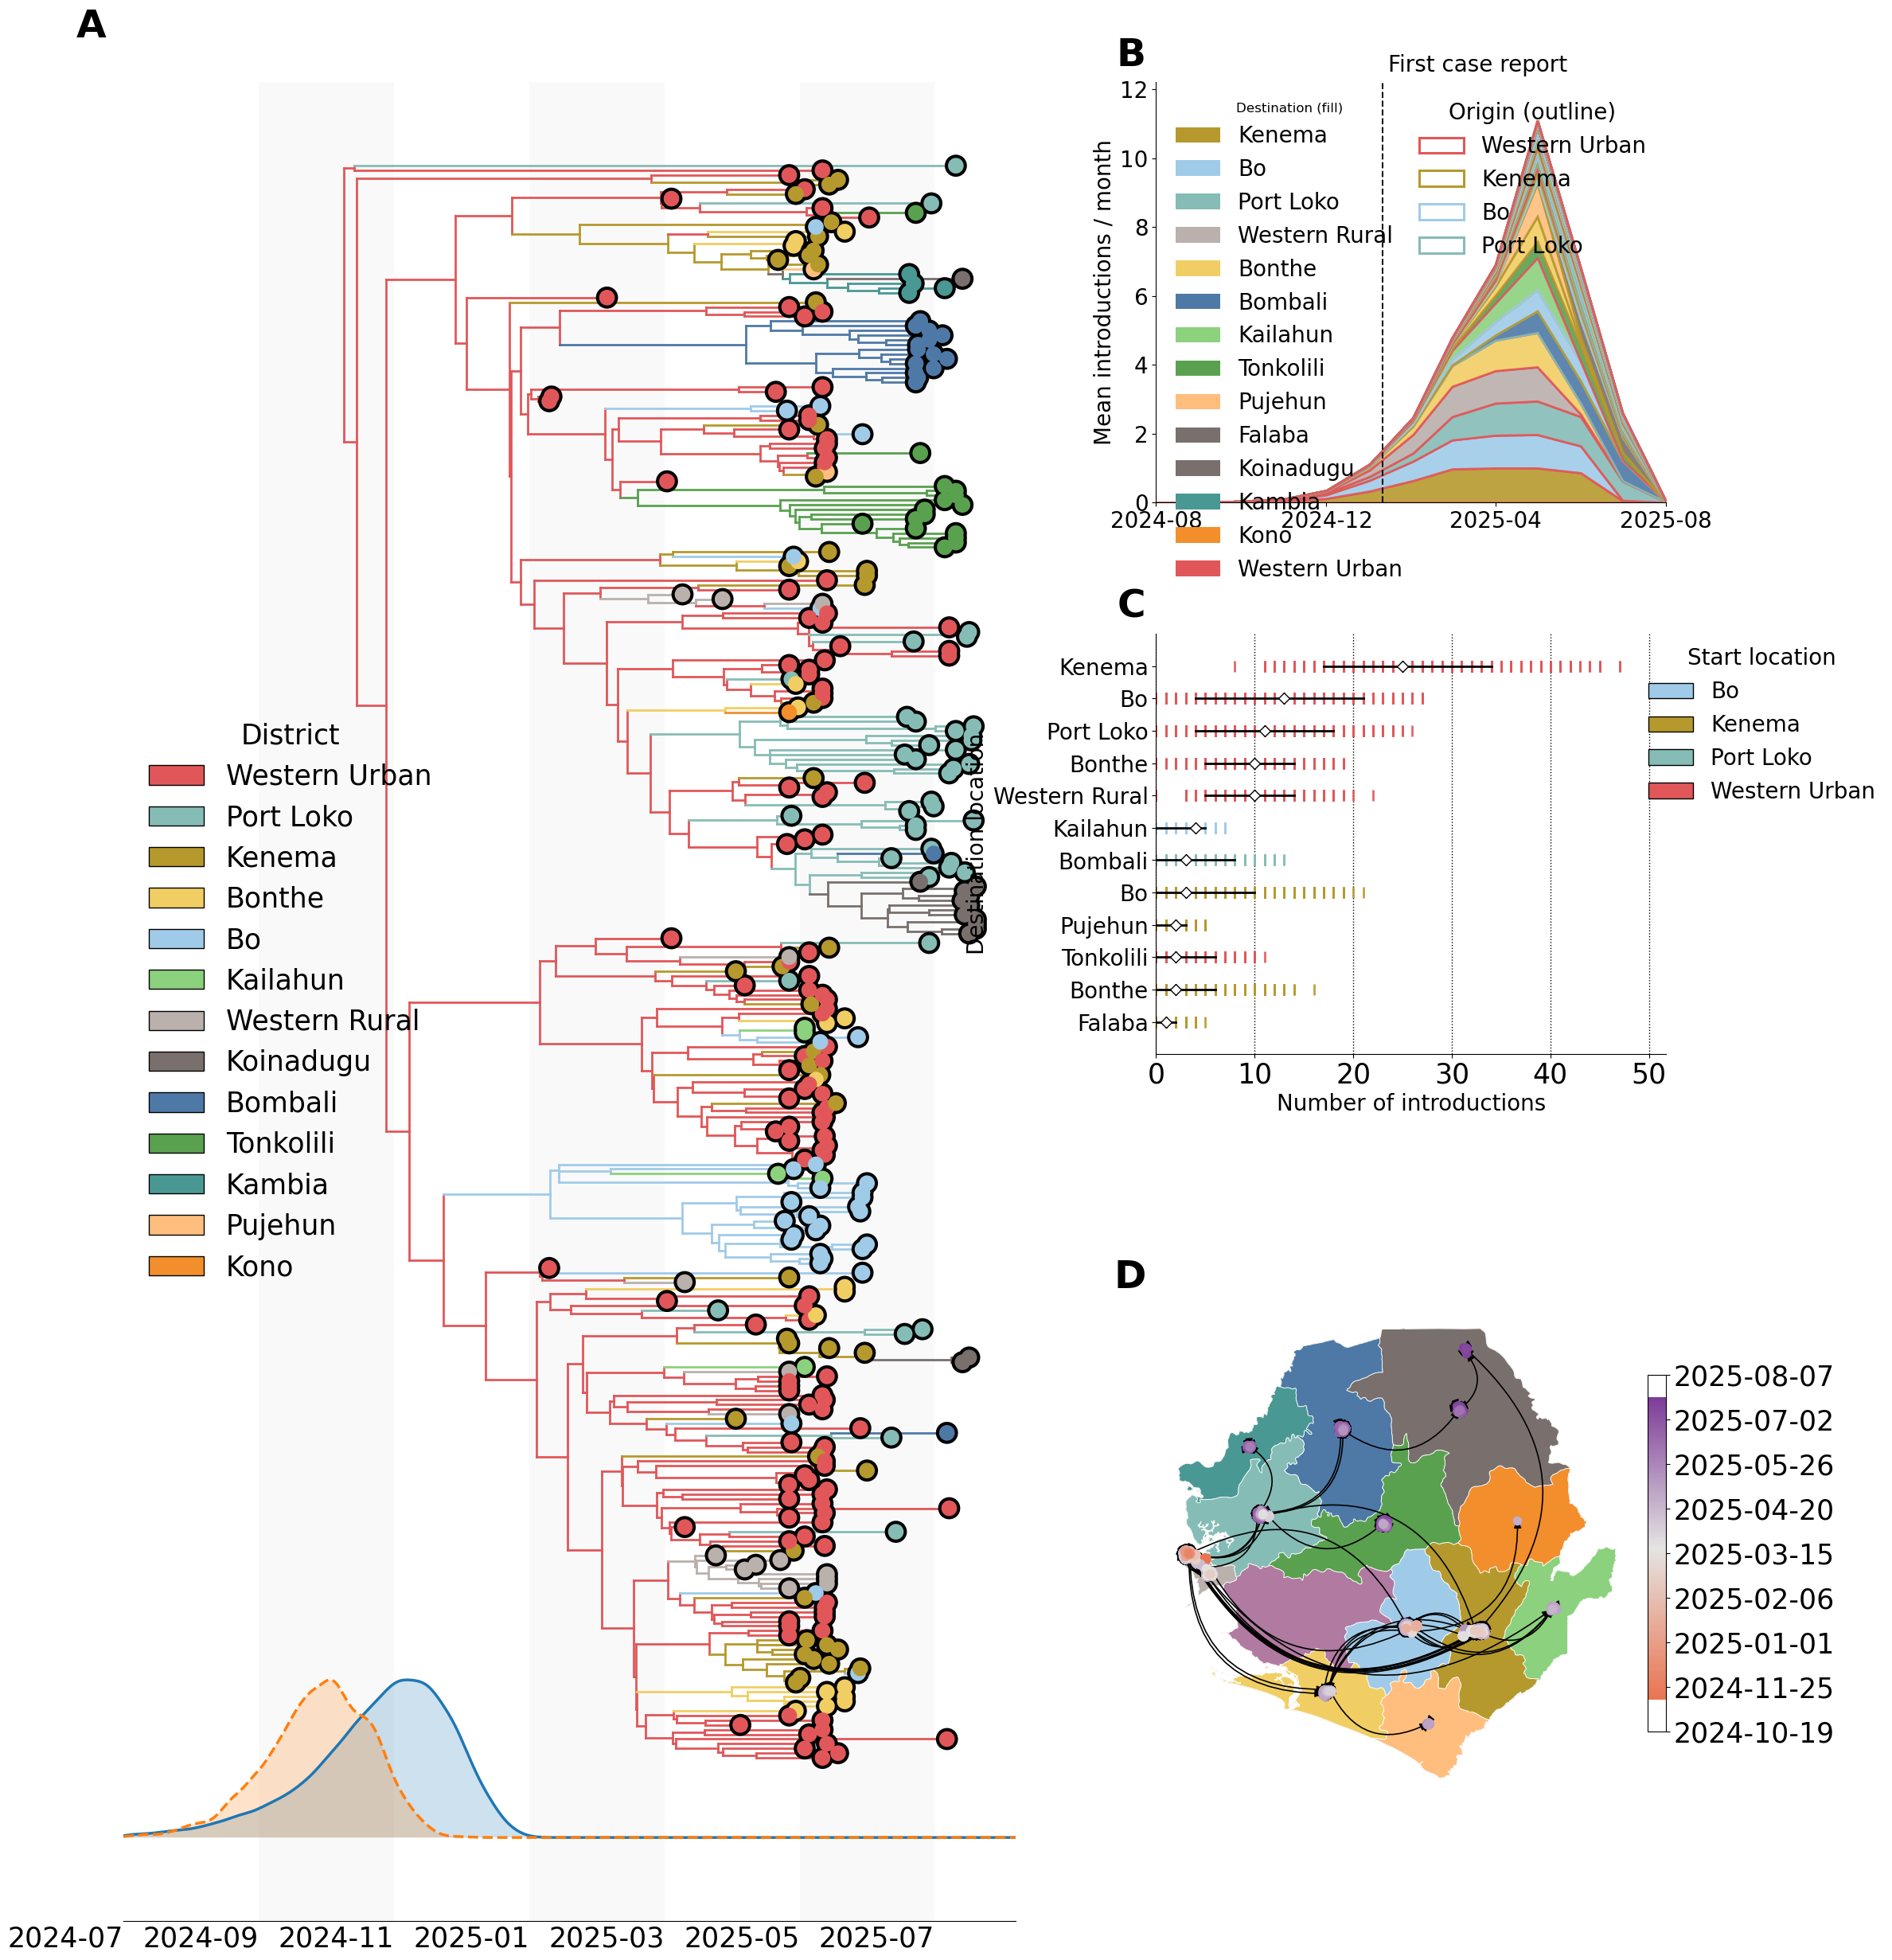

In [157]:
# ─────────────────────────────────────────
# Assemble panels with SubGridSpec (B/C/D stacked)
# ─────────────────────────────────────────
fig = plt.figure(figsize=(25, 30), constrained_layout=False)
gs  = GridSpec(nrows=1, ncols=2, width_ratios=[1.75, 1.0], figure=fig)

# Left column: A (spans full height)
axA = fig.add_subplot(gs[0, 0])

# Right column: split into 3 rows for B, C, D  ← replace this line
right = gs[0, 1].subgridspec(3, 1, height_ratios=[0.8, 0.8, 1.4], hspace=0.25)
axB = fig.add_subplot(right[0, 0])
axC = fig.add_subplot(right[1, 0])
axD = fig.add_subplot(right[2:, 0])



# Draw panels
panel_A_tree(axA)
panel_B_stacked(axB)
panel_C_distributions(axC)
panel_D_map(axD)

# Panel labels
def tag(ax, letter):
    ax.text(-0.02, 1.02, letter, transform=ax.transAxes,
            fontsize=35, fontweight='bold', ha='right', va='bottom')
tag(axA, "A")
tag(axB, "B")
tag(axC, "C")
tag(axD, "D")

# Save / show
fig.savefig("/Volumes/aine_store/SLE+MPOX+September+2025Sept11/CLADE+Artic/SLE_panels_ABCD.png", dpi=300, bbox_inches="tight")
fig.savefig("/Volumes/aine_store/SLE+MPOX+September+2025Sept11/CLADE+Artic/SLE_panels_ABCD.svg", dpi=300, bbox_inches="tight")
fig.savefig("/Volumes/aine_store/SLE+MPOX+September+2025Sept11/CLADE+Artic/SLE_panels_ABCD.pdf", dpi=300, bbox_inches="tight")

plt.show()